In [4]:
import numpy as np 
import matplotlib.pyplot as plt 

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable
import pandas as pd

from scipy.integrate import quad
from scipy import interpolate
from scipy.integrate import quad
from TO_sim.Get_2ndR_NORM import get_r_rp,Make_R_function
from parfor import parfor
from tqdm.notebook import tqdm

In [8]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [45]:
m = 3.9
ms = np.linspace(3.8,10,621)
# @parfor(ms)
def get_Kritical(m):
# rs = np.linspace(0,1,10000)[1:]
    Xs1 = np.logspace(-15,-3,200)
    Xs = np.r_[Xs1,np.linspace(1e-3,100,6001)]

    R0 = np.nan*np.zeros(len(Xs)) # R_0: Lock state oscillator
    RDh = np.nan*np.zeros(len(Xs)) # R_D: Drift oscillators
    OPS = np.nan*np.zeros(len(Xs)) # O_p: Peak frequency of driven oscillator
    
    # Calulate $r_0$ and $r_D$
    for i,X in enumerate(Xs):
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R0[i],err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        RDh[i],err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        OPS[i] = omega_p


    RD = 2*RDh
    R = R0 -RD
    KK = Xs/R
    K_min_arg = np.argmin(KK)
    K_u = KK[K_min_arg:]
    r_u = Xs[K_min_arg:]/K_u
    R_0u = R0[K_min_arg:]
    R_du = -RD[K_min_arg:]
    OPSu = OPS[K_min_arg:]

    R_u = R_0u + R_du
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]

    RPS = []
    RP0s = []
    K1p = []
    
    for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPSu):
        omega_pp = X
        rp = 1e-4 #-rd/2
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = b*K*rp

        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
        RP = (RP_ls-RP_ds)
        RPS.append(RP)
    RPS = np.array(RPS)
    # x, = np.where(RPS+R_du/2>=0)
    x, = np.where(RPS>=2e-5)
    y, = np.where(RPS>=0)
    z, = np.where(RPS>=0)
    K_sd1 = np.nan
    K_su1 = np.nan
    
    K_sd2 = np.nan
    K_su2 = np.nan
    if len(x)>0:
        K_sd1 = K_u[x[0]]
        K_su1 = K_u[x[-1]]
    return K_sd1,K_su1
# get_Kritical = np.vectorize(get_Kritical)

In [46]:
ms1 = np.linspace(3.86,3.87,101)[:-1]

In [47]:
K_sds0 = np.nan * ms1
K_sus0 = np.nan * ms1
for i,m in enumerate(tqdm(ms1)):
    K_sds0[i],K_sus0[i] = get_Kritical(m)

  0%|          | 0/100 [00:00<?, ?it/s]

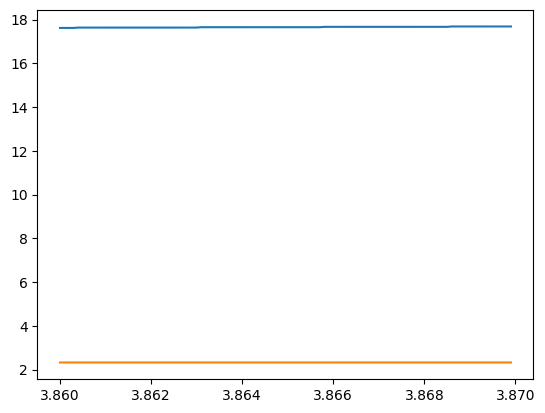

In [48]:
plt.plot(ms1, K_sus0)
plt.plot(ms1, K_sds0)

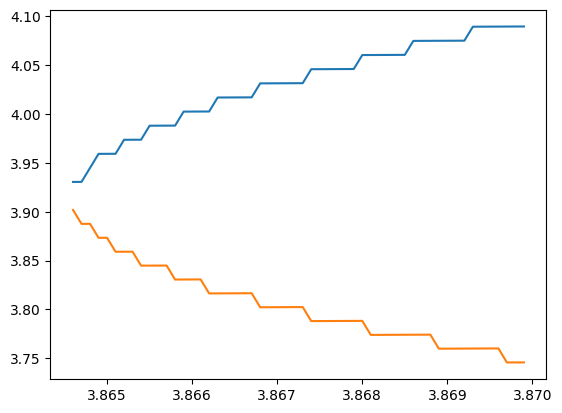

In [19]:
plt.plot(ms1, K_sus0)
plt.plot(ms1, K_sds0)

$$
⟨sin⁡(2𝜔_{(+)} 𝑡 + 𝜃_𝑖 ) ⟩=(𝐾𝑟_+)/(4𝜔_{(+)} (4𝜔_{(+)}^2 𝑚^2+1))→−(𝐾𝑟_+)/(4𝜔_{(+)} (4𝜔_{(+)}^2 𝑚^2+1))
$$

## To prove the solution of $\delta_+$  
```python
delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
``` 
$\rightarrow$
```python
delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
``` 


## Graph $r_0$

In [113]:
K = 4
m = 5.4
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


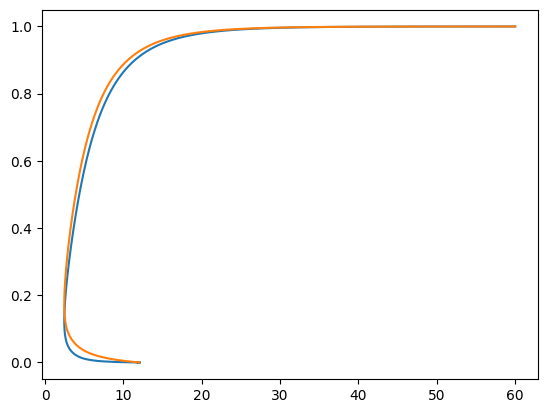

In [114]:
plt.plot(KK,R)
plt.plot(KK,R0)

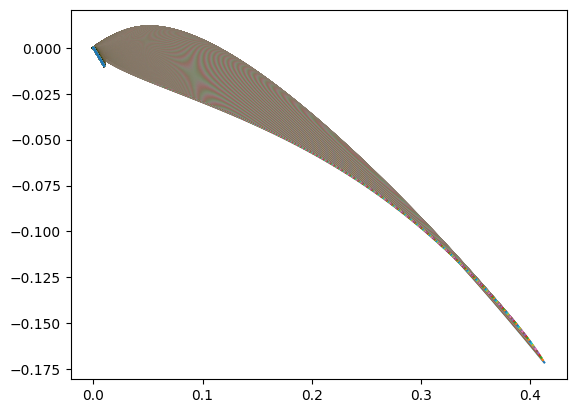

In [128]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    plt.plot(rps,RP-rps)
    
    
    try:
        RP1_u.append(rps[x[-1]])
        RP1_d.append(rps[x[0]])
        RP01_u.append(RP_ls[x[-1]])
        RP01_d.append(RP_ls[x[0]])
        K1p.append(K)
    except:pass

In [ ]:
for X,K,r,r0,rd,OP in list(zip(Xsu,K_u,R_u,R_0u,R_du,OPS))[::10]:
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    plt.plot(rps,RP-rps)
    
    # break

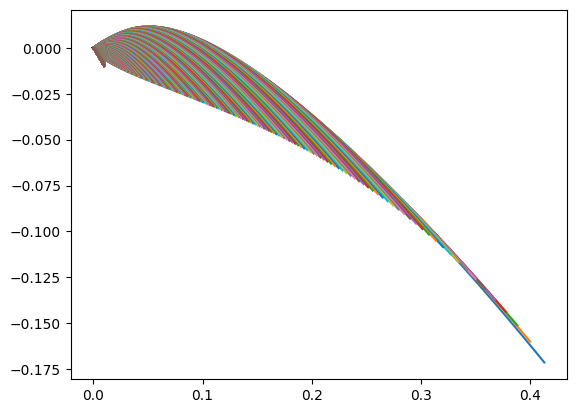

In [126]:
for X,K,r,r0,rd,OP in list(zip(Xsu,K_u,R_u,R_0u,R_du,OPS))[::10]:
    rs1 = np.logspace(-6,-2,100)
    rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    plt.plot(rps,RP-rps)
    
    # break

In [122]:
np.where(RP-rps>=0)

(array([], dtype=int64),)

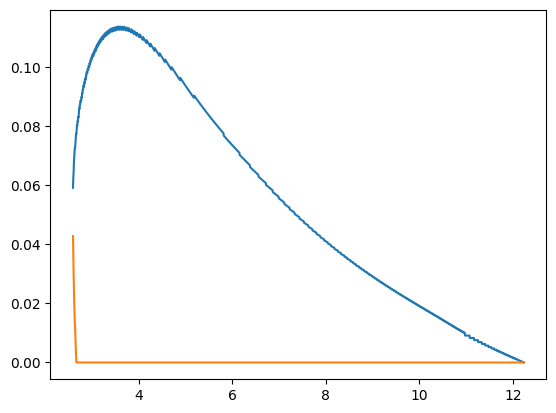

In [129]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)


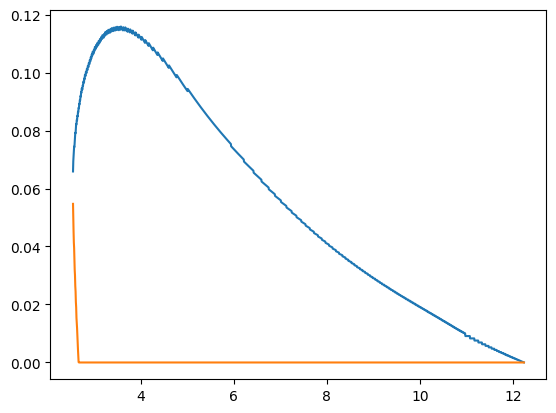

In [127]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)


In [ ]:
F = get_r_Fun(m)

In [ ]:
K = 5
r0 = float(F['u']['R0'](K))
r = float(F['u']['R'](K))
OP = float(F['u']['OPS'](K))
X = K*r

In [64]:
rs1 = np.logspace(-6,-2,100)
rps = np.r_[rs1,np.linspace(1e-2,(1-r0)/2,200)] 
omega_pp = X
RP_ls = np.nan*rps
RP_ds = np.nan*rps

for i,rp in enumerate(rps):
    OPs = K*rp

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
RP = (RP_ls-RP_ds)
x, = np.where((RP-rps)>=0)

IndexError: index 0 is out of bounds for axis 0 with size 0

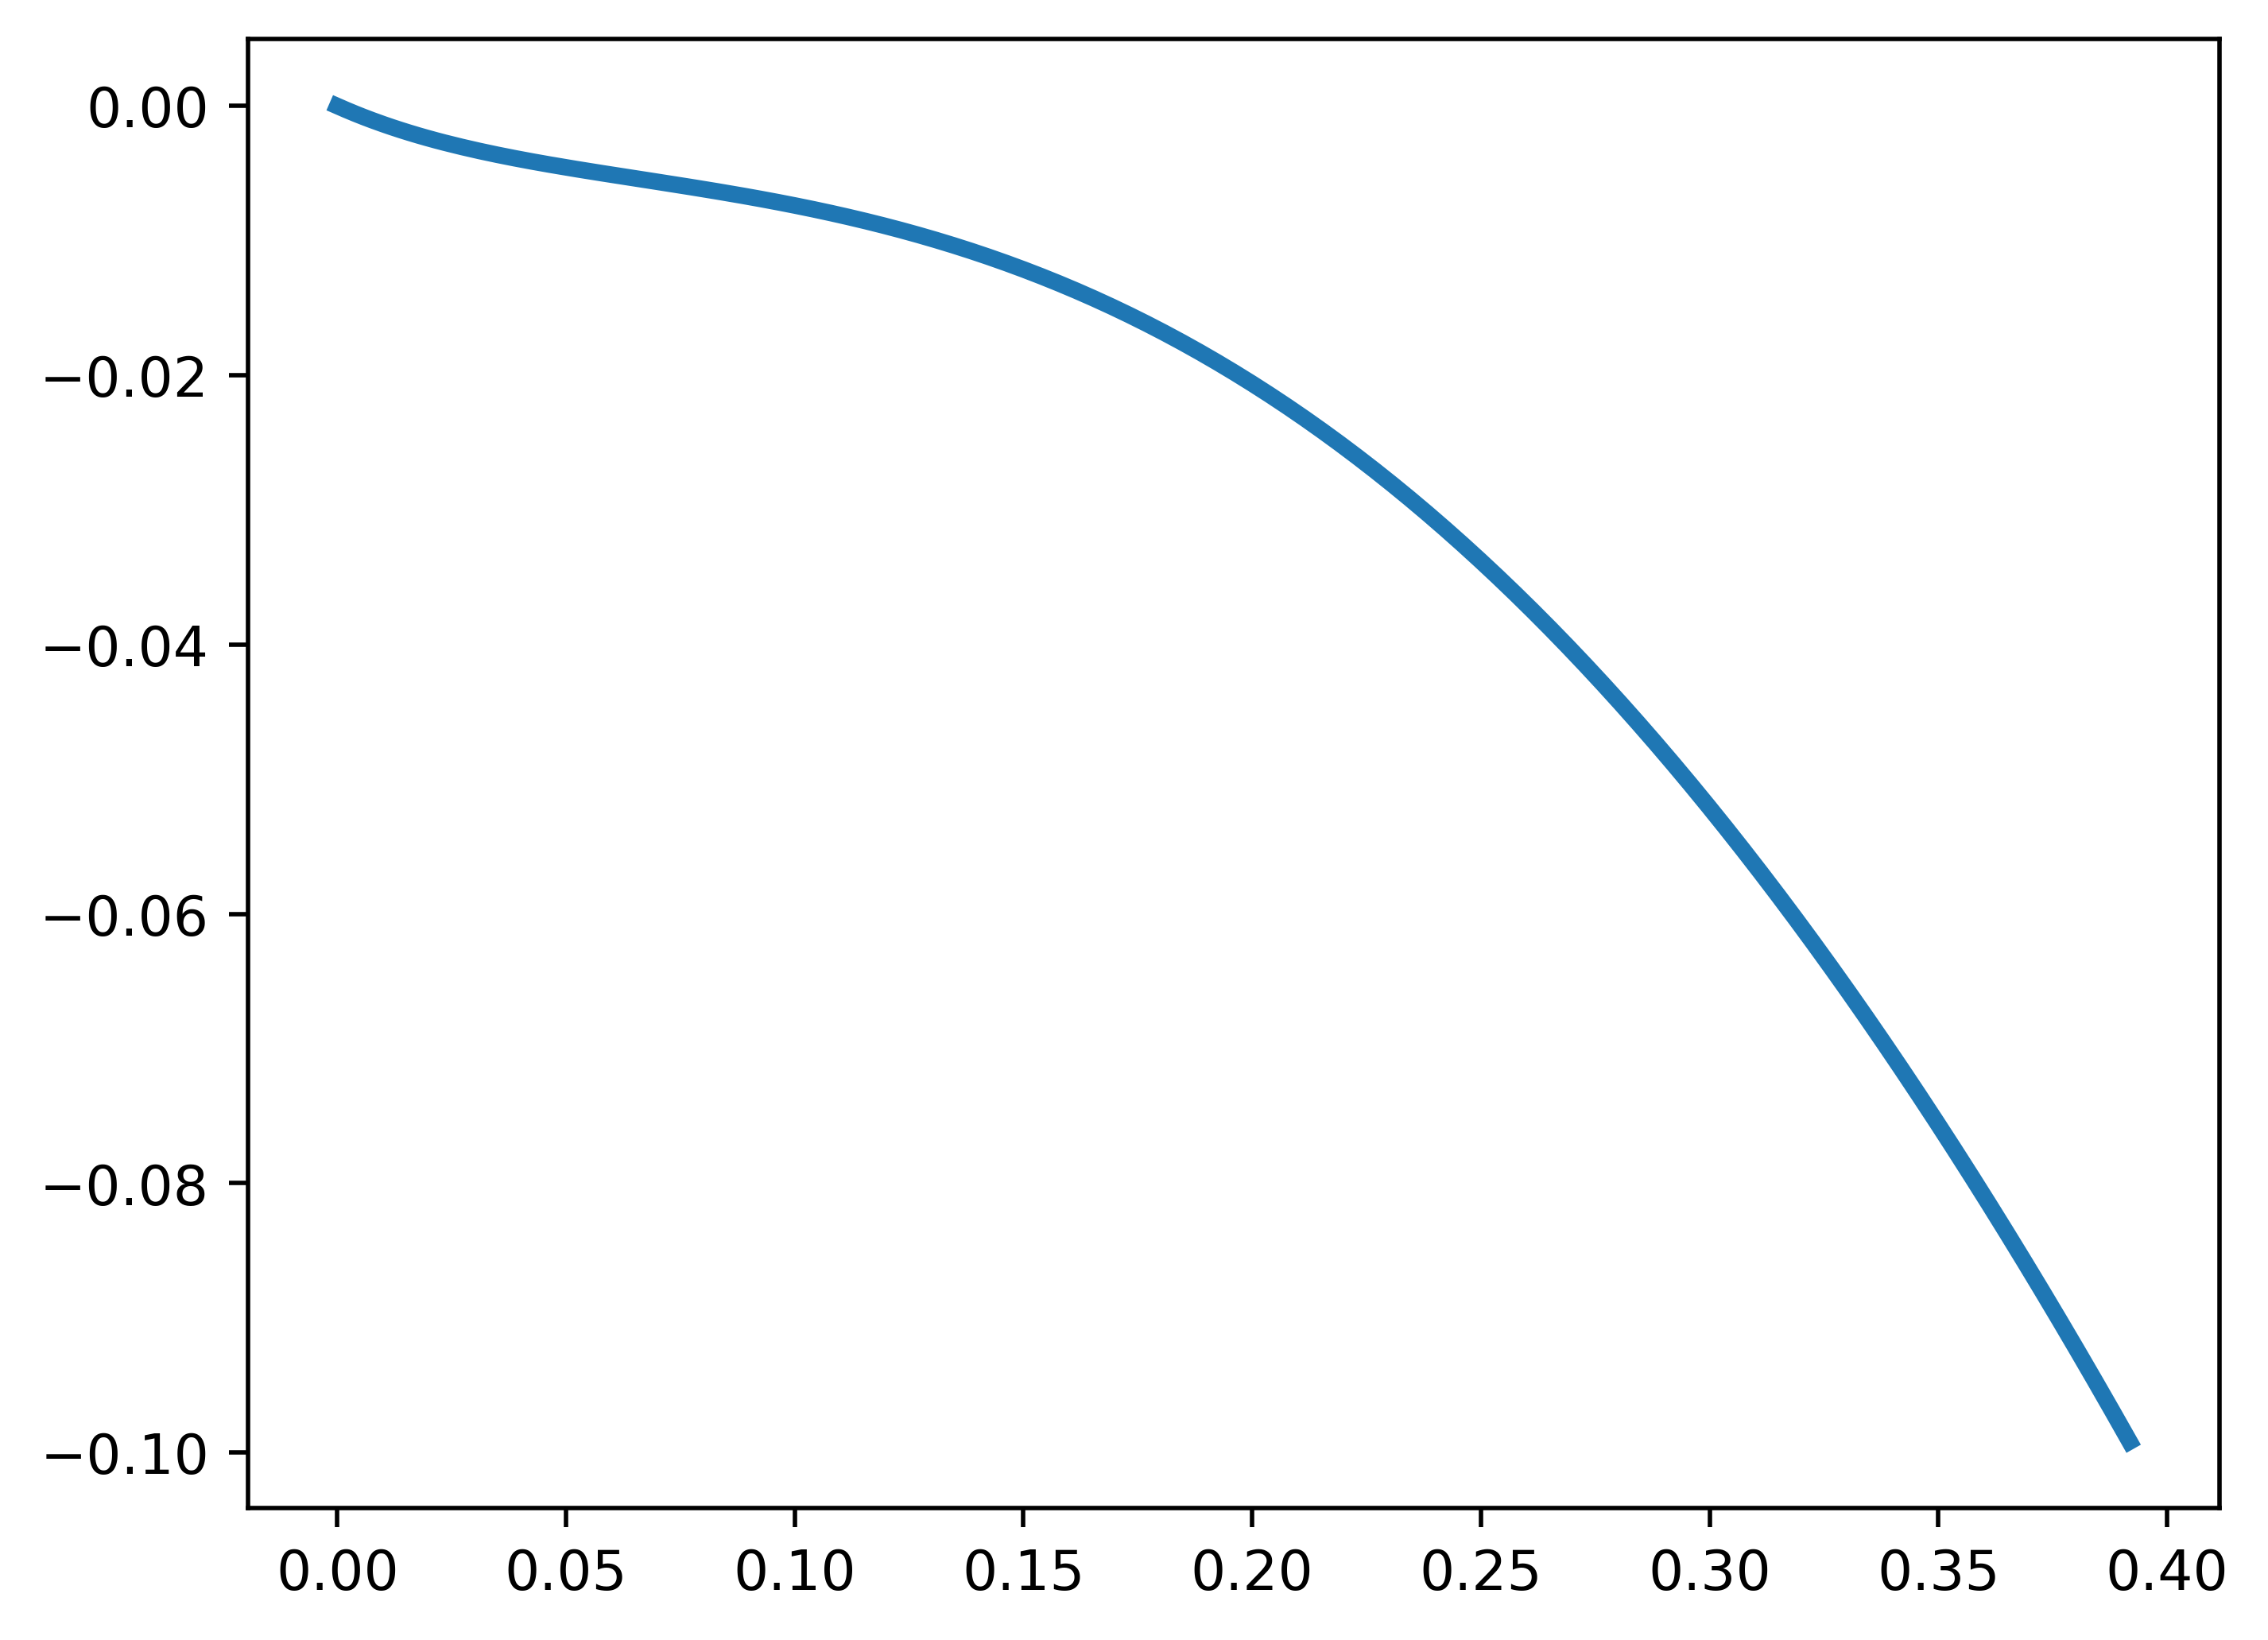

In [65]:
plt.figure(dpi=500)
plt.plot(rps,RP-rps,lw=3)
plt.axvline(rps[x[0]],color='red',ls='--')
plt.axvline(rps[x[-1]],color='red',ls='--')
plt.axhline(0,color='black',ls='--')
# plt.xlim(0,)
plt.xlabel(r'$r_+$',fontsize=15)
plt.ylabel(r'$J(X,r_+)$',fontsize=15)
# plt.title(rf'$X={X:.02f},G(X)={K},m={m}$')